## RDMs analysis

### Helper methods

#### RDMs plotting methods

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations


def join_layers(task_rdms, layer, models):
    joined_rdms = {}
    for model in models:
        model_rdms = task_rdms[model]
        training_modes = models[model]
        for training_mode in training_modes:
            training_mode_rdm = model_rdms[training_mode]
            if layer not in training_mode_rdm:
                continue
            joined_rdms[f'{model}_{training_mode}'] = training_mode_rdm[layer]
    return joined_rdms


def base_name(model_name):
    basename = model_name.split('_')[0]
    if basename == 'bmi':
        return 'BMI'
    elif basename == 'baseline':
        return 'Voxel Representation'
    return basename.capitalize() 


def plot_model_comparisons(comparisons_dict, model_type, layers='all', x_label='Layers', group_by='layer', legend=True, title=None,
                           fig_size=(10, 8)):
    """
    Plot correlation comparisons between models using strip plots with confidence intervals.
    
    Parameters:
    comparisons_dict: Dictionary with structure model1 -> model2 -> layer -> correlations
    model_type: Either 'pretrained' or 'tl' to specify which model versions to compare
    """
    models = [key for key in comparisons_dict.keys() if key.endswith(f'_{model_type}')]
    if model_type == 'tl':
        models += [f'baseline_{model_type}']
    model_pairs = list(combinations(models, 2))
    # order the model pairs to ensure "none" comparisons are first, then the others and finally the baseline
    model_pairs = sorted(model_pairs, key=lambda x: ('none' in x[0].lower(), 'none' in x[1].lower(), x[0], x[1]))
    # ensure baseline is always last
    model_pairs = [pair for pair in model_pairs if 'baseline' not in pair[0] and 'baseline' not in pair[1]] + \
                  [pair for pair in model_pairs if 'baseline' in pair[0] or 'baseline' in pair[1]]
    
    if layers == 'all':
        first_comparison = next(iter(comparisons_dict.values()))
        first_layer_dict = next(iter(first_comparison.values()))
        layers = list(first_layer_dict.keys())
    if not isinstance(layers, list):
        raise ValueError("Layers should be a list of layer names or 'all' to use all available layers.")
    
    data_rows = []
    for layer in layers:
        for model1, model2 in model_pairs:            
            if model1 in comparisons_dict and model2 in comparisons_dict[model1]:
                correlations = comparisons_dict[model1][model2][layer]
            elif model2 in comparisons_dict and model1 in comparisons_dict[model2]:
                correlations = comparisons_dict[model2][model1][layer]
            else:
                continue
            
            comparison = f"{base_name(model1)} vs {base_name(model2)}"
            if 'none' in model1.lower() or 'none' in model2.lower():
                group = 'non-pretrained'
            elif 'baseline' in model1.lower() or 'baseline' in model2.lower():
                group = 'voxel model'
            else:
                group = 'pretrained'
            for corr in correlations:
                data_rows.append({
                    'layer': layer,
                    'comparison': comparison,
                    'correlation': corr,
                    'group': group
                })
    
    df = pd.DataFrame(data_rows)
    color_map = sns.color_palette("deep")
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=fig_size)
    
    if group_by == 'layer':
        x = 'layer'
    else:
        x = 'group'

    ax = sns.boxplot(data=df, x=x, y='correlation', hue='comparison', linewidth=1.5, 
                palette=color_map, fliersize=0.0, legend=legend)
    sns.stripplot(data=df, x=x, y='correlation', hue='comparison', alpha=0.4, size=4, 
                  jitter=True, palette=color_map, dodge=True, ax=ax, legend=legend)

    ax.set_xlabel(x_label, fontsize=15)
    ax.set_ylabel('Correlation Values', fontsize=15)
    if title:
        ax.set_title(title, fontsize=16)
    else:
        ax.set_title(f'{model_type.capitalize()} modalities', fontsize=16)
    sns.despine(ax=ax, left=True)
    
    min_value = round(df['correlation'].min() - 0.05, 1)
    plt.yticks(np.arange(min_value, 1.01, 0.1))

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        n_comparisons = len(model_pairs)
        ax.legend(handles[:n_comparisons], labels[:n_comparisons], ncol=n_comparisons,
                title='Comparisons', loc='lower center', # bbox_to_anchor=(1.05, 1)
                )
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()
    plt.show()
    return fig


def plot_rsa_histogram_grid(compared_rdms, layer, task):
    compared_rdms = compared_rdms[task]
    x_models = [model for model in compared_rdms.keys() if 'pretrained' in model]
    y_model_pairs = [(f'{y_model.split('_')[0]}_pretrained', f'{y_model.split('_')[0]}_tl') for y_model in x_models]
    
    sns.set_theme()
    fig, axes = plt.subplots(len(y_model_pairs), len(x_models), figsize=(10, 8))
    fig.tight_layout(pad=3.0)
    
    plt.subplots_adjust(top=0.9)
    parsed_task_title = task.replace('ad_vs_hc', 'AD and HC')
    parsed_task_title = parsed_task_title.replace('ad_vs_mci', 'AD and MCI')
    parsed_task_title = parsed_task_title.replace('mci_vs_hc', 'MCI and HC')
    fig.suptitle(f'RSA Analysis on {parsed_task_title} subjects for layer {layer}', fontsize=14)

    all_values = []
    for x_model in x_models:
        for y_pretrained, y_finetuned in y_model_pairs:
            all_values.extend(compared_rdms[x_model][y_pretrained][layer])
            all_values.extend(compared_rdms[x_model][y_finetuned][layer])
    global_min = min(all_values)
    global_max = max(all_values)
    padding = (global_max - global_min) * 0.05
    global_min -= padding
    global_max += padding
    
    for col, x_model in enumerate(x_models):
        model_name = x_model.split('_')[0]
        if model_name == 'bmi': model_name = 'BMI'
        col_title = f'Similarity to {model_name} prediction model'
        axes[0, col].set_title(col_title, fontsize=11)
    
    for row, (pretrained, _) in enumerate(y_model_pairs):
        model_name = pretrained.split('_')[0].capitalize()
        if model_name == 'Bmi': model_name = 'BMI'
        ylabel = f'{model_name} prediction\n before and after fine-tuning'
        axes[row, 0].set_ylabel(ylabel, fontsize=10)
    
    # Set common x and y labels
    fig.text(0.5, 0.02, 'Correlation value', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Similarity density', va='center', rotation='vertical', fontsize=14)
    
    pretrained_color = sns.color_palette()[0]
    finetuned_color = sns.color_palette()[1]
    for row, (y_pretrained, y_finetuned) in enumerate(y_model_pairs):
        for col, x_model in enumerate(x_models):
            ax = axes[row, col]
            ax.set_yticks([])
            if col > 0:
                ax.set_yticklabels([])
            if row < len(y_model_pairs) - 1:
                ax.set_xticks([])
            else:
                ax.tick_params(axis='x', labelsize=10)

            pretrained_data = compared_rdms[x_model][y_pretrained][layer]
            finetuned_data = compared_rdms[x_model][y_finetuned][layer]
            if row != col:            
                sns.kdeplot(pretrained_data, ax=ax, fill=True, alpha=0.5, color=pretrained_color,
                        label=f'vs {y_pretrained}', linewidth=1, bw_adjust=0.8, legend=False)
            else:
                ax.axvline(x=1, color=pretrained_color, lw=2, alpha=0.7)
            sns.kdeplot(finetuned_data, ax=ax, fill=True, alpha=0.5, color=finetuned_color,
                      label=f'vs {y_finetuned}', linewidth=1, bw_adjust=0.8, legend=False)

            ax.set_xlim(global_min, global_max)
            ax.grid(alpha=0.3)

    handles = [
        plt.Line2D([0], [0], color=pretrained_color, lw=4, alpha=0.7),
        plt.Line2D([0], [0], color=finetuned_color, lw=4, alpha=0.7)
    ]
    labels = ['Pretrained', 'Fine-tuned']
    fig.legend(handles, labels, fontsize=10, frameon=True, loc='upper left')
    
    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])  # Adjust the rect parameter to make room for labels
    
    return fig


def parse_task_name(task):
    if task == 'ad_vs_hc':
        return 'AD vs HC'
    elif task == 'ad_vs_mci':
        return 'AD vs MCI'
    elif task == 'mci_vs_hc':
        return 'MCI vs HC'
    return task

def plot_representational_shifts(representational_shifts):
    models = [m.lower() for m in representational_shifts.keys()]
    tasks = list(next(iter(representational_shifts.values())).keys())
    colors = ['#E74C3C', '#3498DB', '#2ECC71']  # Red, Blue, Green for tasks

    fig, ax = plt.subplots(figsize=(7, 5))
    x = np.arange(len(models))

    # Plot each task (no lines, just points)
    for i, task in enumerate(tasks):
        y = [representational_shifts[m][task][0] for m in models]
        # add the standard error (representational_shifts[m][task][1])
        yerr = [representational_shifts[m][task][1] for m in models]
        ax.scatter(x, y, color=colors[i], label=parse_task_name(task), s=80, alpha=0.7)
        ax.errorbar(x, y, yerr=yerr, fmt='o', color=colors[i], alpha=0.7)

    # Plot mean
    means = [np.mean([representational_shifts[m][task][0] for task in tasks]) for m in models]
    ax.scatter(x, means, color='black', label='Mean', s=80, marker='D')

    ax.set_xticks(x)
    ax.set_xticklabels(['Age finetuned', 'Sex finetuned', 'BMI finetuned'], fontsize=11)
    ax.set_ylabel('Distance to pretrained representation', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.legend(title='Task', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

In [2]:
def plot_rsa_histogram_grid(compared_rdms, layer, tasks, only_diagonal=False):
    """
    Plots a grid of RSA histograms for the specified layer and tasks.
    If only_diagonal is True, plots a grid where columns are tasks and rows are models.
    """
    sns.set_theme()
    pretrained_color = sns.color_palette()[0]
    finetuned_color = sns.color_palette()[1]

    if only_diagonal:
        # Get all models from the first task
        first_task_rdms = compared_rdms[tasks[0]]
        models = [model for model in first_task_rdms.keys() if 'pretrained' in model]
        n_models = len(models)
        n_tasks = len(tasks)
        fig, axes = plt.subplots(n_models, n_tasks, figsize=(4 * n_tasks, 4 * n_models), squeeze=False)

        # Compute global x-axis limits across all plots
        all_values = []
        for model in models:
            for task in tasks:
                task_rdms = compared_rdms[task]
                y_pretrained = f"{model.split('_')[0]}_pretrained"
                y_finetuned = f"{model.split('_')[0]}_tl"
                all_values.extend(task_rdms[model][y_pretrained][layer])
                all_values.extend(task_rdms[model][y_finetuned][layer])
        global_min = min(all_values)
        global_max = max(all_values)
        padding = (global_max - global_min) * 0.05
        global_min -= padding
        global_max += padding

        for row, model in enumerate(models):
            model_name = model.split('_')[0].capitalize()
            if model_name == 'Bmi': model_name = 'BMI'
            for col, task in enumerate(tasks):
                ax = axes[row, col]
                task_rdms = compared_rdms[task]
                y_pretrained = f"{model.split('_')[0]}_pretrained"
                y_finetuned = f"{model.split('_')[0]}_tl"
                pretrained_data = task_rdms[model][y_pretrained][layer]
                finetuned_data = task_rdms[model][y_finetuned][layer]
                ax.axvline(x=1, color=pretrained_color, lw=2, alpha=0.7)
                sns.kdeplot(finetuned_data, ax=ax, fill=True, alpha=0.5, color=finetuned_color,
                            label=f'vs {y_finetuned}', linewidth=1, bw_adjust=0.8, legend=False)
                ax.set_xlim(global_min, global_max)
                ax.set_yticks([])

                # Only show y-labels on first column
                if col == 0:
                    ax.set_ylabel('Similarity density', fontsize=12)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])

                # Only show x-ticks and x-labels on bottom row
                if row == n_models - 1:
                    ax.set_xlabel('Correlation value', fontsize=12)
                    ax.tick_params(axis='x', labelsize=10)
                else:
                    ax.set_xlabel('')
                    ax.set_xticklabels([])

                # Only show titles in the first row
                if row == 0:
                    parsed_task_title = task.replace('ad_vs_hc', 'AD vs HC').replace('ad_vs_mci', 'AD vs MCI').replace('mci_vs_hc', 'MCI vs HC')
                    ax.set_title(parsed_task_title, fontsize=13)
                else:
                    ax.set_title('')

                ax.grid(alpha=0.3)

        handles = [
            plt.Line2D([0], [0], color=pretrained_color, lw=4, alpha=0.7),
            plt.Line2D([0], [0], color=finetuned_color, lw=4, alpha=0.7)
        ]
        labels = ['Pretrained', 'Fine-tuned']
        fig.legend(handles, labels, fontsize=10, frameon=True, loc='upper left')
        plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
        return fig

    # Original grid plotting for a single task (backward compatibility)
    if isinstance(tasks, str):
        task = tasks
    else:
        task = tasks[0]
    compared_rdms = compared_rdms[task]
    x_models = [model for model in compared_rdms.keys() if 'pretrained' in model]
    y_model_pairs = [(f'{y_model.split("_")[0]}_pretrained', f'{y_model.split("_")[0]}_tl') for y_model in x_models]

    fig, axes = plt.subplots(len(y_model_pairs), len(x_models), figsize=(10, 8))
    fig.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.9)
    parsed_task_title = task.replace('ad_vs_hc', 'AD and HC')
    parsed_task_title = parsed_task_title.replace('ad_vs_mci', 'AD and MCI')
    parsed_task_title = parsed_task_title.replace('mci_vs_hc', 'MCI and HC')
    fig.suptitle(f'RSA Analysis on {parsed_task_title} subjects for layer {layer}', fontsize=14)

    all_values = []
    for x_model in x_models:
        for y_pretrained, y_finetuned in y_model_pairs:
            all_values.extend(compared_rdms[x_model][y_pretrained][layer])
            all_values.extend(compared_rdms[x_model][y_finetuned][layer])
    global_min = min(all_values)
    global_max = max(all_values)
    padding = (global_max - global_min) * 0.05
    global_min -= padding
    global_max += padding

    for col, x_model in enumerate(x_models):
        model_name = x_model.split('_')[0]
        if model_name == 'bmi': model_name = 'BMI'
        col_title = f'Similarity to {model_name} prediction model'
        axes[0, col].set_title(col_title, fontsize=11)

    for row, (pretrained, _) in enumerate(y_model_pairs):
        model_name = pretrained.split('_')[0].capitalize()
        if model_name == 'Bmi': model_name = 'BMI'
        ylabel = f'{model_name} prediction\n before and after fine-tuning'
        axes[row, 0].set_ylabel(ylabel, fontsize=10)

    fig.text(0.5, 0.02, 'Correlation value', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Similarity density', va='center', rotation='vertical', fontsize=14)

    for row, (y_pretrained, y_finetuned) in enumerate(y_model_pairs):
        for col, x_model in enumerate(x_models):
            ax = axes[row, col]
            ax.set_yticks([])
            if col > 0:
                ax.set_yticklabels([])
            if row < len(y_model_pairs) - 1:
                ax.set_xticks([])
            else:
                ax.tick_params(axis='x', labelsize=10)

            pretrained_data = compared_rdms[x_model][y_pretrained][layer]
            finetuned_data = compared_rdms[x_model][y_finetuned][layer]
            if row != col:            
                sns.kdeplot(pretrained_data, ax=ax, fill=True, alpha=0.5, color=pretrained_color,
                            label=f'vs {y_pretrained}', linewidth=1, bw_adjust=0.8, legend=False)
            else:
                ax.axvline(x=1, color=pretrained_color, lw=2, alpha=0.7)
            sns.kdeplot(finetuned_data, ax=ax, fill=True, alpha=0.5, color=finetuned_color,
                        label=f'vs {y_finetuned}', linewidth=1, bw_adjust=0.8, legend=False)

            ax.set_xlim(global_min, global_max)
            ax.grid(alpha=0.3)

    handles = [
        plt.Line2D([0], [0], color=pretrained_color, lw=4, alpha=0.7),
        plt.Line2D([0], [0], color=finetuned_color, lw=4, alpha=0.7)
    ]
    labels = ['Pretrained', 'Fine-tuned']
    fig.legend(handles, labels, fontsize=10, frameon=True, loc='upper left')
    plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
    return fig

#### PCA plotting methods

In [ ]:
def detect_outliers(pretrained, finetuned, method='iqr', factor=1.5):
    movement_distances = np.sqrt(np.sum((finetuned - pretrained)**2, axis=1))
    
    if method == 'iqr':
        Q1 = np.percentile(movement_distances, 25)
        Q3 = np.percentile(movement_distances, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        mask = (movement_distances >= lower_bound) & (movement_distances <= upper_bound)
    elif method == 'zscore':
        z_scores = np.abs((movement_distances - np.mean(movement_distances)) / np.std(movement_distances))
        mask = z_scores < factor
    else:
        raise ValueError("Method must be 'iqr' or 'zscore'")
    
    return mask

def get_task_labels():
    """Get class labels for each task."""
    return {
        'ad_vs_hc': ('AD', 'HC'),
        'ad_vs_mci': ('AD', 'MCI'), 
        'mci_vs_hc': ('MCI', 'HC')
    }

def get_model_colors():
    """Get color palette for different models."""
    return {
        'age': '#E74C3C',      # Red
        'bmi': '#3498DB',      # Blue  
        'sex': '#2ECC71',      # Green
        'none': '#9B59B6'      # Purple
    }

def get_modality_markers():
    """Get markers for different modalities."""
    return {'Pretrained': 'o', 'Finetuned': 's'}

def get_class_colors():
    """Get colors for different classes."""
    return {'first': '#FF6B6B', 'second': '#4ECDC4'}

def prepare_data(pcas, remove_outliers=False):
    pretrained = pcas['pretrained']
    finetuned = pcas['finetuned']
    n_removed = 0
    
    if remove_outliers:
        outlier_mask = detect_outliers(pretrained, finetuned)
        pretrained = pretrained[outlier_mask]
        finetuned = finetuned[outlier_mask]
        n_removed = np.sum(~outlier_mask)
    
    return pretrained, finetuned, n_removed

def plot_pca(tasks_pcas, model_name, save_path=None, remove_outliers=False):
    task_labels = get_task_labels()
    markers = get_modality_markers()
    class_colors = get_class_colors()
    
    n_tasks = len(tasks_pcas)
    fig, axes = plt.subplots(2, n_tasks, figsize=(5*n_tasks, 10))
    if n_tasks == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (task, models) in enumerate(tasks_pcas.items()):
        if model_name not in models:
            print(f"Warning: Model '{model_name}' not found in task '{task}'. Skipping.")
            continue
            
        # Prepare data
        pretrained, finetuned, n_removed = prepare_data(models[model_name], remove_outliers)
        if n_removed > 0:
            print(f"Task {task}: Removed {n_removed} outliers from {model_name} model")
        
        # Split data by class (first half vs second half)
        n_samples = len(pretrained)
        split_idx = n_samples // 2
        class1_label, class2_label = task_labels.get(task, ('Class1', 'Class2'))
        
        pretrained_class1 = pretrained[:split_idx]
        pretrained_class2 = pretrained[split_idx:]
        finetuned_class1 = finetuned[:split_idx]
        finetuned_class2 = finetuned[split_idx:]
        
        # Top row: Scatter plots comparing both conditions with class discrimination
        ax_top = axes[0, idx]
        
        # Plot pretrained data with different colors for each class
        ax_top.scatter(pretrained_class1[:, 0], pretrained_class1[:, 1], 
                      c=class_colors['first'], alpha=0.6, s=30, marker=markers['Pretrained'],
                      label=f'Pretrained {class1_label}', edgecolors='white', linewidth=0.5)
        ax_top.scatter(pretrained_class2[:, 0], pretrained_class2[:, 1], 
                      c=class_colors['second'], alpha=0.6, s=30, marker=markers['Pretrained'],
                      label=f'Pretrained {class2_label}', edgecolors='white', linewidth=0.5)
        
        # Plot finetuned data with different colors for each class  
        ax_top.scatter(finetuned_class1[:, 0], finetuned_class1[:, 1], 
                      c=class_colors['first'], alpha=0.6, s=30, marker=markers['Finetuned'],
                      label=f'Finetuned {class1_label}', edgecolors='white', linewidth=0.5)
        ax_top.scatter(finetuned_class2[:, 0], finetuned_class2[:, 1], 
                      c=class_colors['second'], alpha=0.6, s=30, marker=markers['Finetuned'],
                      label=f'Finetuned {class2_label}', edgecolors='white', linewidth=0.5)
        
        ax_top.set_xlabel('PC1')
        ax_top.set_ylabel('PC2')
        ax_top.set_title(f'{task.upper()}: {model_name.upper()} PCA Comparison')
        ax_top.legend()
        ax_top.grid(True, alpha=0.3)
        
        # Bottom row: Difference visualization (arrows showing movement)
        ax_bottom = axes[1, idx]
        
        # Calculate movement vectors for both classes
        movement_vectors_class1 = finetuned_class1 - pretrained_class1
        movement_vectors_class2 = finetuned_class2 - pretrained_class2
        
        # Plot arrows showing the movement from pretrained to finetuned for each class
        for i in range(len(pretrained_class1)):
            ax_bottom.arrow(pretrained_class1[i, 0], pretrained_class1[i, 1],
                           movement_vectors_class1[i, 0], movement_vectors_class1[i, 1],
                           head_width=0.02, head_length=0.02, 
                           fc=class_colors['first'], ec=class_colors['first'], alpha=0.3, length_includes_head=True)
        
        for i in range(len(pretrained_class2)):
            ax_bottom.arrow(pretrained_class2[i, 0], pretrained_class2[i, 1],
                           movement_vectors_class2[i, 0], movement_vectors_class2[i, 1],
                           head_width=0.02, head_length=0.02, 
                           fc=class_colors['second'], ec=class_colors['second'], alpha=0.3, length_includes_head=True)
        
        # Plot starting (pretrained) and ending (finetuned) points with class discrimination
        ax_bottom.scatter(pretrained_class1[:, 0], pretrained_class1[:, 1], 
                         c=class_colors['first'], alpha=0.8, s=40, marker=markers['Pretrained'],
                         label=f'Pretrained {class1_label}', edgecolors='white', linewidth=0.5)
        ax_bottom.scatter(pretrained_class2[:, 0], pretrained_class2[:, 1], 
                         c=class_colors['second'], alpha=0.8, s=40, marker=markers['Pretrained'],
                         label=f'Pretrained {class2_label}', edgecolors='white', linewidth=0.5)
        ax_bottom.scatter(finetuned_class1[:, 0], finetuned_class1[:, 1], 
                         c=class_colors['first'], alpha=0.8, s=40, marker=markers['Finetuned'],
                         label=f'Finetuned {class1_label}', edgecolors='white', linewidth=0.5)
        ax_bottom.scatter(finetuned_class2[:, 0], finetuned_class2[:, 1], 
                         c=class_colors['second'], alpha=0.8, s=40, marker=markers['Finetuned'],
                         label=f'Finetuned {class2_label}', edgecolors='white', linewidth=0.5)
        
        ax_bottom.set_xlabel('PC1')
        ax_bottom.set_ylabel('PC2')
        ax_bottom.set_title(f'{task.upper()}: {model_name.upper()} Movement Vectors')
        ax_bottom.legend()
        ax_bottom.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return fig

def plot_pca_models(tasks_pcas, task_name, model_names='all', save_path=None, remove_outliers=False):
    if task_name not in tasks_pcas:
        print(f"Warning: Task '{task_name}' not found. Available tasks: {list(tasks_pcas.keys())}")
        return None
    
    model_colors = get_model_colors()
    markers = get_modality_markers()
    
    models = tasks_pcas[task_name]
    if model_names == 'all':
        available_models = list(models.keys())
    else:
        available_models = [model_names] if isinstance(model_names, str) else list(model_names)
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    for model_name in available_models:
        if model_name not in model_colors:
            print(f"Warning: No color defined for model '{model_name}'. Skipping.")
            continue
            
        # Get model color
        base_color = model_colors[model_name]
        
        # Handle the 'none' model which only has finetuned data
        if model_name == 'none':
            # Only plot finetuned data for 'none' model
            if 'finetuned' in models[model_name]:
                finetuned_data = models[model_name]['finetuned']
                
                # Apply outlier removal if requested (compare with itself as baseline)
                if remove_outliers:
                    # For 'none' model, we can't use movement distance, so use position-based outliers
                    distances_from_center = np.sqrt(np.sum((finetuned_data - np.mean(finetuned_data, axis=0))**2, axis=1))
                    if len(distances_from_center) > 0:
                        Q1 = np.percentile(distances_from_center, 25)
                        Q3 = np.percentile(distances_from_center, 75)
                        IQR = Q3 - Q1
                        upper_bound = Q3 + 1.5 * IQR
                        outlier_mask = distances_from_center <= upper_bound
                        finetuned_data = finetuned_data[outlier_mask]
                        n_removed = np.sum(~outlier_mask)
                        if n_removed > 0:
                            print(f"Model {model_name}: Removed {n_removed} outliers")
                
                # Plot only finetuned data
                ax.scatter(finetuned_data[:, 0], finetuned_data[:, 1], 
                          c=base_color, alpha=0.8, s=30, marker=markers['Finetuned'],
                          label=f'{model_name.upper()} (No Pretraining)', edgecolors='white', linewidth=0.5)
        else:
            # Handle regular models with both pretrained and finetuned data
            # Prepare data
            pretrained, finetuned, n_removed = prepare_data(models[model_name], remove_outliers)
            if n_removed > 0:
                print(f"Model {model_name}: Removed {n_removed} outliers")
            
            # Plot pretrained data
            ax.scatter(pretrained[:, 0], pretrained[:, 1], 
                      c=base_color, alpha=0.6, s=30, marker=markers['Pretrained'],
                      label=f'{model_name.upper()} Pretrained', edgecolors='white', linewidth=0.5)
            
            # Plot finetuned data
            ax.scatter(finetuned[:, 0], finetuned[:, 1], 
                      c=base_color, alpha=0.8, s=30, marker=markers['Finetuned'],
                      label=f'{model_name.upper()} Finetuned', edgecolors='white', linewidth=0.5)
            
            # Plot movement arrows (commented out to reduce clutter)
            # movement_vectors = finetuned - pretrained
            # for i in range(len(pretrained)):
            #     ax.arrow(pretrained[i, 0], pretrained[i, 1],
            #             movement_vectors[i, 0], movement_vectors[i, 1],
            #             head_width=0.02, head_length=0.02, 
            #             fc=base_color, ec=base_color, alpha=0.2, length_includes_head=True)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'{task_name.upper()}: All Models Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return fig


def plot_all_pcas(tasks_pcas, **kwargs):
    # Get all available models from the first task
    first_task = list(tasks_pcas.keys())[0]
    available_models = list(tasks_pcas[first_task].keys())
    
    print(f"Available models: {available_models}")
    
    for model in available_models:
        print(f"\nPlotting model: {model.upper()}")
        try:
            plot_pca(tasks_pcas, model, **kwargs)
        except Exception as e:
            print(f"Error plotting model '{model}': {e}")


def plot_all_tasks_pcas(tasks_pcas, **kwargs):
    available_tasks = list(tasks_pcas.keys())
    
    print(f"Available tasks: {available_tasks}")
    
    for task in available_tasks:
        print(f"\nPlotting models comparison for task: {task.upper()}")
        try:
            plot_pca_models(tasks_pcas, task, **kwargs)
        except Exception as e:
            print(f"Error plotting task '{task}': {e}")

### Definitions

In [3]:
from pretrain_exp.rsa import compare_models, plot_maps, load_task_rdms
from pathlib import Path

base_path = Path('pretrain_exp')
rdms_file, batches_file = 'rdms.pkl', 'batches.pkl'
rdms_path = base_path / 'results'
tasks = ['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc']
models = ['age', 'sex', 'bmi', 'none']
layers = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6']
ad_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_hc')
ad_vs_mci_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_mci')
mci_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'mci_vs_hc')

### Compute comparisons

In [4]:
n_iters = 100
random_state = 42
comparisons_dict = compare_models(tasks, models, layers, rdms_path, n_iters, random_state)

### RDMs

In [ ]:
age_ft_rdms = plot_maps(mci_vs_hc_rdms['age']['tl'], 'Age finetuned', ['MCI', 'HC'], layers=layers + ['fc6'])

In [ ]:
ad_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_hc')
ad_vs_mci_rdms, _ = load_task_rdms(rdms_path, 'ad_vs_mci')
mci_vs_hc_rdms, _ = load_task_rdms(rdms_path, 'mci_vs_hc')

age_ft_rdms = plot_maps(ad_vs_hc_rdms['age']['tl'], 'Age finetuned', ['AD', 'HC'], layers=layers + ['fc6'])
age_ft_rdms = plot_maps(ad_vs_mci_rdms['age']['tl'], 'Age finetuned', ['AD', 'MCI'], layers=layers + ['fc6'])
age_ft_rdms = plot_maps(mci_vs_hc_rdms['age']['tl'], 'Age finetuned', ['MCI', 'HC'], layers=layers + ['fc6'])

### Pretrained comparisons

In [ ]:
fig = plot_model_comparisons(comparisons_dict['ad_vs_hc'], model_type='pretrained', legend=False)
# fig.savefig('ad_vs_hc_pretrained_comparisons.png', dpi=300)

### Finetuned comparisons

In [ ]:
fig = plot_model_comparisons(comparisons_dict['ad_vs_hc'], model_type='tl', layers=['conv1'], legend=True, 
                             x_label='Convolutional layer 1', title='Finetuned and non-pretrained modalities',
                             fig_size=(10, 7.9))
# fig.savefig('ad_vs_hc_tl_comparisons.png', dpi=300)

### Histogram similarity

Task: ad_vs_hc
Model: age, Representational Shift: 0.667480 ± 0.002937
Model: sex, Representational Shift: 1.007441 ± 0.001828
Model: bmi, Representational Shift: 0.881359 ± 0.003330
Task: ad_vs_mci
Model: age, Representational Shift: 0.358494 ± 0.003614
Model: sex, Representational Shift: 0.990572 ± 0.002356
Model: bmi, Representational Shift: 0.742771 ± 0.004048
Task: mci_vs_hc
Model: age, Representational Shift: 0.711913 ± 0.001765
Model: sex, Representational Shift: 0.978862 ± 0.001692
Model: bmi, Representational Shift: 0.862285 ± 0.001938


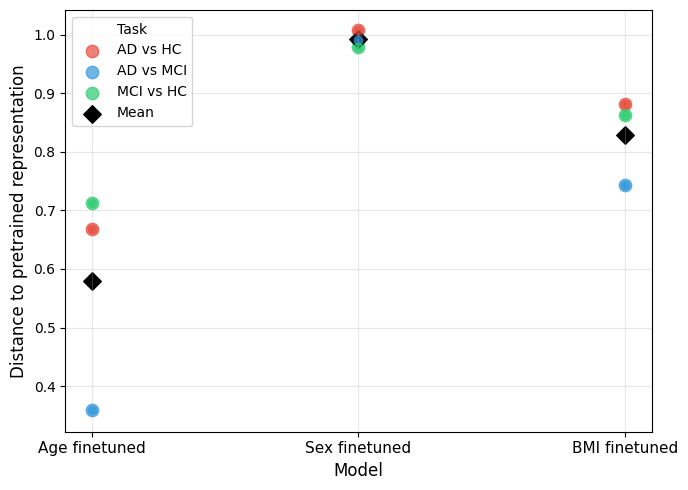

In [10]:
from scipy.stats import sem
from numpy import median, array, mean, abs
layer = 'conv5'
tasks = ['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc']
representational_shifts = {}
for task in tasks:
    print(f'Task: {task}')
    for model in comparisons_dict[task]:
        if model.endswith('_tl'):
            continue
        model_name = model.split('_')[0]
        if not model_name in representational_shifts:
            representational_shifts[model_name] = {}
        finetuned_model = model_name + '_tl'
        comparison_with_self = array(comparisons_dict[task][model][model][layer])
        comparison_with_finetuned = array(comparisons_dict[task][model][finetuned_model][layer])
        representational_shift = abs(comparison_with_self - comparison_with_finetuned)
        representational_shifts[model_name][task] = [mean(representational_shift), sem(representational_shift)]
        print(f'Model: {model_name}, Representational Shift: {mean(representational_shift):.6f} ± {sem(representational_shift):.6f}')

plot_representational_shifts(representational_shifts)

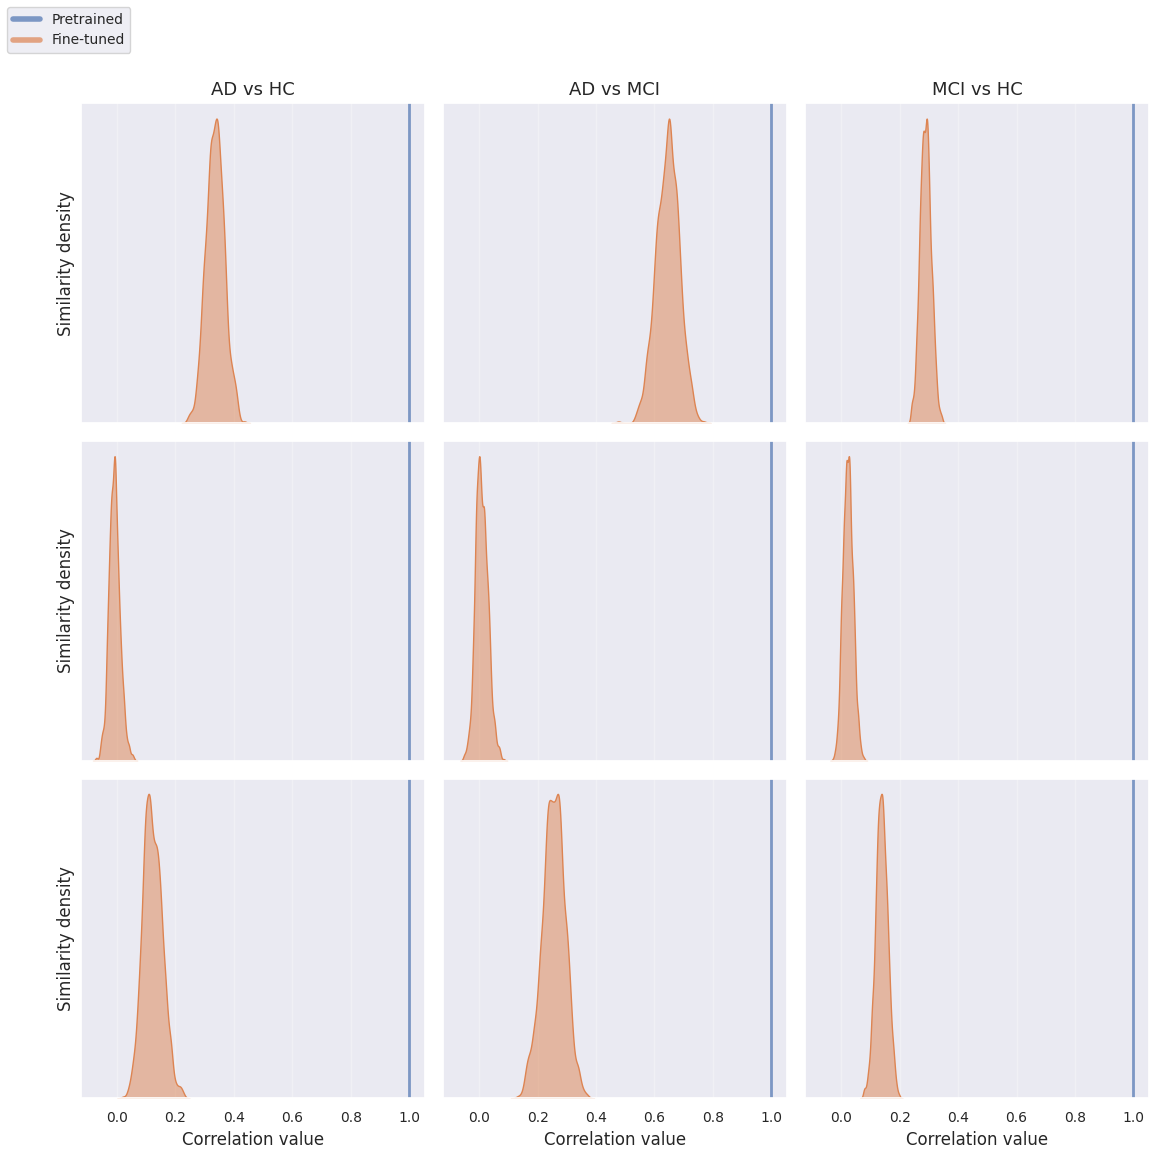

In [27]:
fig = plot_rsa_histogram_grid(comparisons_dict, layer='conv5', tasks=['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc'], only_diagonal=True)

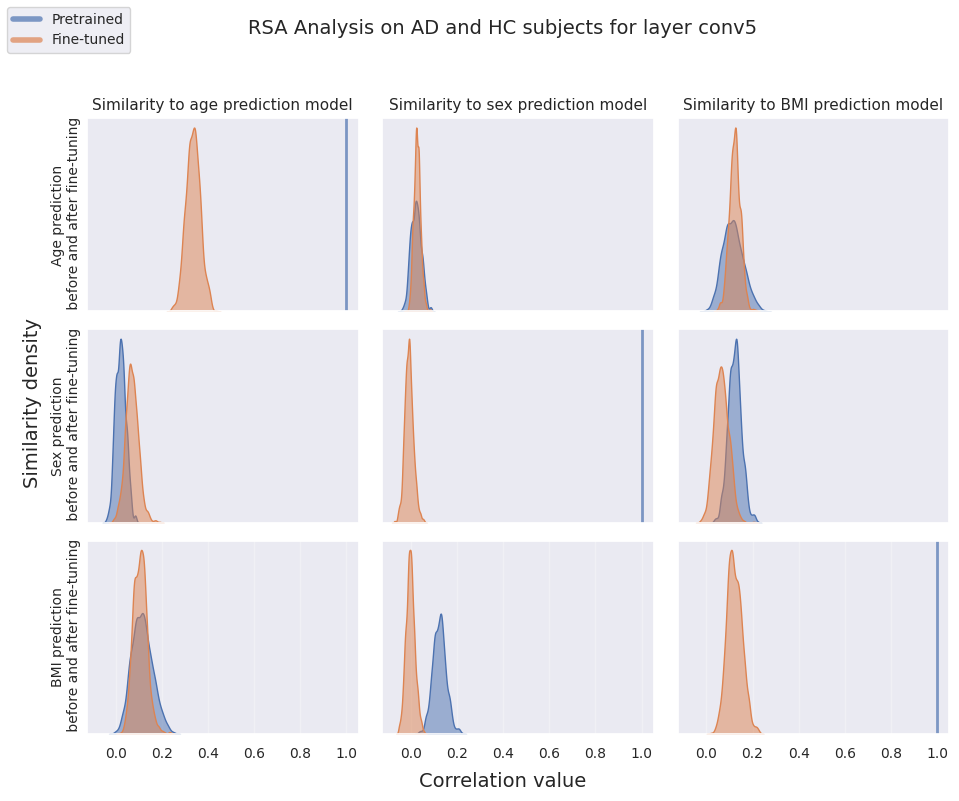

In [4]:
layer, task = 'conv5', 'ad_vs_hc'
fig = plot_rsa_histogram_grid(comparisons_dict, layer, task=task)
# fig.savefig(base_path / 'results' / f'rsa_histogram_{task}_{layer}.png', dpi=300, bbox_inches='tight')
plt.show()

### PCA Convolutional layer 5

In [ ]:
import pickle

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
results_path = Path('pretrain_exp') / 'results'
tasks = ['ad_vs_hc', 'ad_vs_mci', 'mci_vs_hc']
tasks_pcas = {}
for task in tasks:
    with open(results_path / task / f'conv5_pcas.pkl', 'rb') as f:
        tasks_pcas[task] = pickle.load(f)

#### Within model

In [ ]:
model_to_plot = 'age' 
figure = plot_pca(tasks_pcas, model_to_plot, save_path=f"pca_{model_to_plot}.png", remove_outliers=True)

#### Across models

In [ ]:
task_to_plot = 'mci_vs_hc'
figure = plot_pca_models(tasks_pcas, task_to_plot,
                         model_names='all',
                         save_path=None, 
                         remove_outliers=True)